<a href="https://colab.research.google.com/github/kartiknarayansahoo/deep_learning_specialization/blob/main/deep%20learning%20for%20audio/music_genre_classification_CNN_and_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as transforms

In [2]:
# !mkdir genres && wget http://opihi.cs.uvic.ca/sound/genres.tar.gz && tar -xf genres.tar.gz genres/

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kartiknarayansahoo","key":"c012ab23cb935b13db86de3f948892c4"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          12310        390  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9843        301  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01           1098         28  1.0              
whenamancodes/credit-card-customers-prediction                  Credit Card Cust

In [6]:
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:54<00:00, 23.7MB/s]
100% 1.21G/1.21G [00:54<00:00, 23.7MB/s]


In [7]:
! mkdir genres
! unzip gtzan-dataset-music-genre-classification.zip -d genres 

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: genres/Data/features_30_sec.csv  
  inflating: genres/Data/features_3_sec.csv  
  inflating: genres/Data/genres_original/blues/blues.00000.wav  
  inflating: genres/Data/genres_original/blues/blues.00001.wav  
  inflating: genres/Data/genres_original/blues/blues.00002.wav  
  inflating: genres/Data/genres_original/blues/blues.00003.wav  
  inflating: genres/Data/genres_original/blues/blues.00004.wav  
  inflating: genres/Data/genres_original/blues/blues.00005.wav  
  inflating: genres/Data/genres_original/blues/blues.00006.wav  
  inflating: genres/Data/genres_original/blues/blues.00007.wav  
  inflating: genres/Data/genres_original/blues/blues.00008.wav  
  inflating: genres/Data/genres_original/blues/blues.00009.wav  
  inflating: genres/Data/genres_original/blues/blues.00010.wav  
  inflating: genres/Data/genres_original/blues/blues.00011.wav  
  inflating: genres/Data/genres_original/blues/blues.00012.wav  
  infla

In [2]:
import os
data_dir = 'genres/Data/genres_original'

print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)

['classical', 'rock', 'disco', 'metal', 'pop', 'hiphop', 'country', 'jazz', 'reggae', 'blues']
['classical', 'rock', 'disco', 'metal', 'pop', 'hiphop', 'country', 'jazz', 'reggae', 'blues']


In [7]:
os.listdir()
if 'img_data' in os.listdir():
    print('Present')
else:
    print('not present')

Present


In [3]:
metal_files = os.listdir(data_dir + "/metal")
print('No. of training examples for metal: ', len(metal_files))
print(metal_files[:5])

No. of training examples for metal:  100
['metal.00046.wav', 'metal.00011.wav', 'metal.00027.wav', 'metal.00066.wav', 'metal.00092.wav']


In [4]:
blues_files = os.listdir(data_dir + "/blues")
print('No. of training examples for blues: ', len(blues_files))

No. of training examples for blues:  100


# Converting music to spectrum images

In [8]:
import librosa
import librosa.display
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imsave

In [9]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = classes
if 'img_data' not in os.listdir():
    for g in genres:
        pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
        for filename in os.listdir(f'{data_dir}/{g}'):
            songname = f'{data_dir}/{g}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=5)
            plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
            plt.axis('off')
            plt.savefig(f'img_data/{g}/{filename[:-3].replace(".","")}.png')

<Figure size 576x576 with 0 Axes>

In [11]:
if 'img_data.zip' not in os.listdir():
    !zip -r img_data.zip img_data


# Visualizing the spectogram

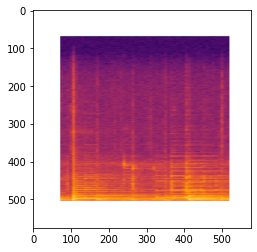

Shape of image is:  (576, 576, 4)


In [12]:
import matplotlib.pyplot as plt
img = plt.imread('img_data'+'/blues/blues00093.png')
imgplot = plt.imshow(img)
plt.show()
print('Shape of image is: ', img.shape)

# Creating the dataset

In [13]:
from torchvision.datasets import ImageFolder

batch_size = 8

train_data = ImageFolder('img_data', transform=ToTensor())
val_data = ImageFolder('img_data', transform=ToTensor()) 

In [14]:
torch.manual_seed(43)
val_size = (int(len(train_data)*0.1))
train_size = len(train_data)-val_size

In [15]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(843, 93)

In [16]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

images.shape:  torch.Size([8, 3, 576, 576])


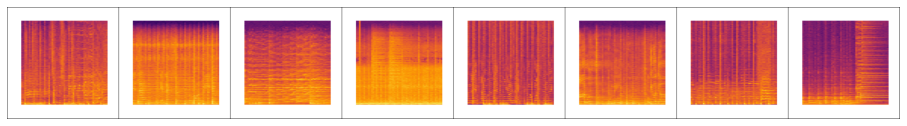

In [17]:
# visualising the image in dataset
for images, _ in train_dl:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Creating the CNN model

In [20]:
# class MusicCNNModel(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(3, 576, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(576, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10))
        
#     def forward(self, xb):
#         return self.network(xb)

In [21]:
import torchvision.models as models
class ResNetModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [22]:
model = ResNetModel()
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [23]:
for images, labels in train_dl:
    print('images.shape: ', images.shape)
    out = model(images)
    print('out.shape: ', out.shape)
    print('out[0]: ', out[0])
    break

images.shape:  torch.Size([8, 3, 576, 576])
out.shape:  torch.Size([8, 10])
out[0]:  tensor([-0.4327, -0.7260,  0.5662,  0.1998, -0.5089,  0.9763, -0.3925,  0.0582,
        -0.7643,  0.7745], grad_fn=<SelectBackward0>)


In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the model

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(ResNetModel(), device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
evaluate(model, val_dl)


{'val_loss': 2.5635533332824707, 'val_acc': 0.08814102411270142}

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)